In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
def resize_images(input_folder, output_folder, image_size):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Iterate through the subfolders in the input folder
    for root, dirs, files in os.walk(input_folder):
        for dir_name in dirs:
            input_subfolder = os.path.join(root, dir_name)
            output_subfolder = os.path.join(output_folder, dir_name)
            
            # Create the corresponding output subfolder
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)
            
            # Iterate through the images in the subfolder
            for file_name in os.listdir(input_subfolder):
                image_path = os.path.join(input_subfolder, file_name)
                output_path = os.path.join(output_subfolder, file_name)
                
                try:
                    # Read the image using OpenCV
                    img = cv2.imread(image_path)
                    
                    # Check if the image is valid
                    if img is not None:
                        # Resize the image
                        img = cv2.resize(img, (image_size, image_size))
                        
                        # Save the resized image to the output subfolder
                        cv2.imwrite(output_path, img)
                    else:
                        print(f"Invalid image: {image_path}")
                except Exception as e:
                    print(f"Error resizing image: {image_path}")
                    print(f"Error details: {str(e)}")


In [7]:
input_folder = "/Users/juinnshengna/Desktop/mri/MRI Images/Training"
output_folder = "/Users/juinnshengna/Desktop/mri/MRI Images/Training2"
image_size = 256


resize_images(input_folder, output_folder, image_size)

In [8]:
input_folder = "/Users/juinnshengna/Desktop/mri/MRI Images/Testing"
output_folder = "/Users/juinnshengna/Desktop/mri/MRI Images/Testing2"
image_size = 256


resize_images(input_folder, output_folder, image_size)

In [49]:
imagesize = 256
batchsize = 32
epochs = 20
channels = 3

In [10]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory("MRI_cleaned/Training2/", shuffle=True, image_size=(imagesize, imagesize), batch_size= batchsize)

Found 2870 files belonging to 4 classes.


In [11]:
class_names = training_dataset.class_names
class_names


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [12]:
len(training_dataset)

90

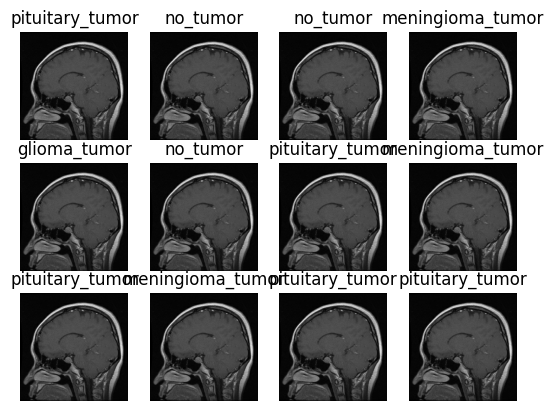

In [13]:
for image_batch, label_batch in training_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [15]:
train_size = 0.8
len(training_dataset)*0.8

72.0

In [17]:
train_ds = training_dataset.take(72)
len(train_ds)

72

In [18]:
val_size = 0.1
len(training_dataset)*0.1

9.0

In [20]:
test_ds = training_dataset.skip(72)
len(test_ds)

18

In [21]:
val_ds = training_dataset.take(6)
len(val_ds)

6

In [22]:
test_ds = test_ds.skip(6)
len(test_ds)

12

In [26]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(training_dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, test_ds, val_ds

In [27]:
train_ds, test_ds, val_ds = get_dataset_partition_tf(training_dataset)

In [29]:
#Caching
len(train_ds)

72

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imagesize, imagesize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [32]:
#Take care of any images resizing

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [45]:
input_shape = (batchsize, imagesize, imagesize, channels)
n_classes = 4
model = models.Sequential([
    resize_and_rescale, data_augmentation, 
    layers.Conv2D(32, (2,2), activation='relu', padding = 'same', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (32, 256, 256, 32)        416       
                                                                 
 max_pooling2d_37 (MaxPooli  (32, 128, 128, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (32, 127, 127, 64)        8256      
                                                                 
 max_pooling2d_38 (MaxPooli  (32, 63, 63, 64)          0         
 ng2D)                                                

In [47]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size = batchsize,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
72/72 [==============================] - 33s 459ms/step - loss: 0.7315 - accuracy: 0.7057 - val_loss: 0.6438 - val_accuracy: 0.7396
Epoch 2/20
72/72 [==============================] - 33s 463ms/step - loss: 0.7263 - accuracy: 0.6845 - val_loss: 0.6452 - val_accuracy: 0.7396
Epoch 3/20
72/72 [==============================] - 33s 457ms/step - loss: 0.6695 - accuracy: 0.7313 - val_loss: 0.6396 - val_accuracy: 0.7049
Epoch 4/20
72/72 [==============================] - 34s 479ms/step - loss: 0.6597 - accuracy: 0.7361 - val_loss: 0.6836 - val_accuracy: 0.6840
Epoch 5/20
72/72 [==============================] - 37s 515ms/step - loss: 0.6637 - accuracy: 0.7266 - val_loss: 0.6159 - val_accuracy: 0.7222
Epoch 6/20
72/72 [==============================] - 34s 476ms/step - loss: 0.6519 - accuracy: 0.7426 - val_loss: 0.6081 - val_accuracy: 0.7465
Epoch 7/20
72/72 [==============================] - 34s 468ms/step - loss: 0.5861 - accuracy: 0.7674 - val_loss: 0.5157 - val_accuracy: 0.7569

In [51]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 2s 108ms/step - loss: 0.3372 - accuracy: 0.8646


In [52]:
scores

[0.3372010886669159, 0.8645833134651184]

In [53]:
history

In [54]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 72}

In [55]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
history.history['accuracy']

[0.7057291865348816,
 0.6844618320465088,
 0.7313368320465088,
 0.7361111044883728,
 0.7265625,
 0.7426215410232544,
 0.7673611044883728,
 0.7669270634651184,
 0.7747395634651184,
 0.7708333134651184,
 0.7795138955116272,
 0.7760416865348816,
 0.7890625,
 0.8029513955116272,
 0.8107638955116272,
 0.8211805820465088,
 0.8116319179534912,
 0.8376736044883728,
 0.8207465410232544,
 0.8485243320465088]

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

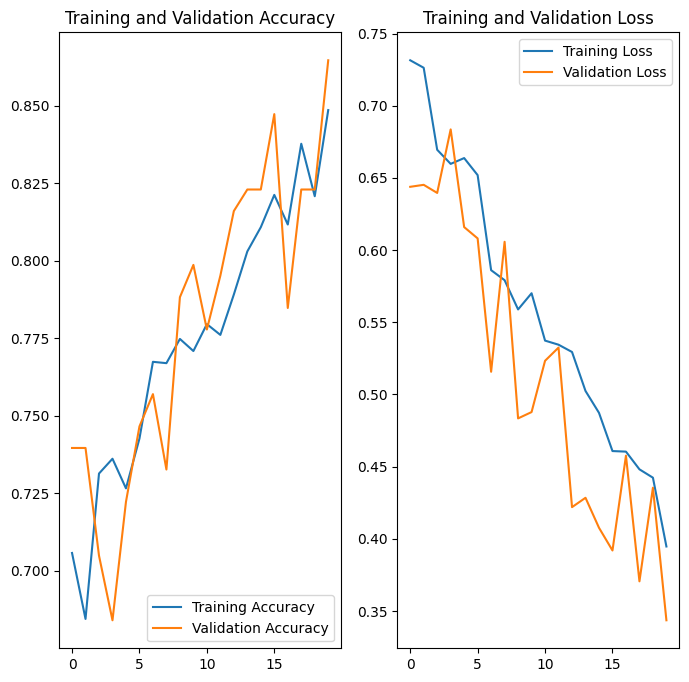

In [65]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label = 'Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label = 'Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

first image to predict
first image's actual label: pituitary_tumor
1/1 [==============================] - 0s 280ms/step
[0.00827895 0.01820176 0.00640276 0.9671166 ]


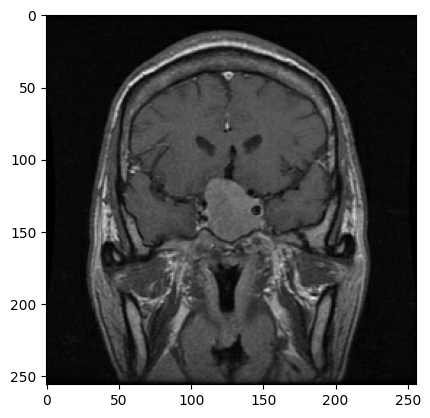

In [69]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])

first image to predict
first image's actual label: pituitary_tumor
1/1 [==============================] - 0s 184ms/step
[0.92286426 0.06857526 0.00495577 0.00360477]


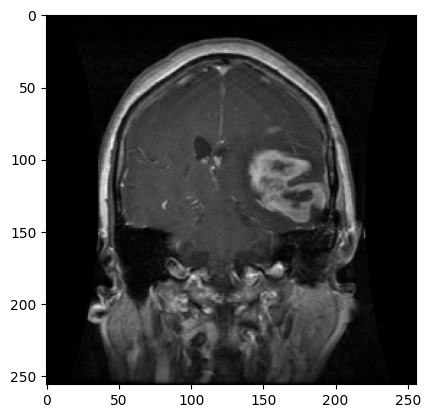

In [70]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])

first image to predict
first image's actual label: pituitary_tumor
1/1 [==============================] - 0s 149ms/step
predicted label: pituitary_tumor


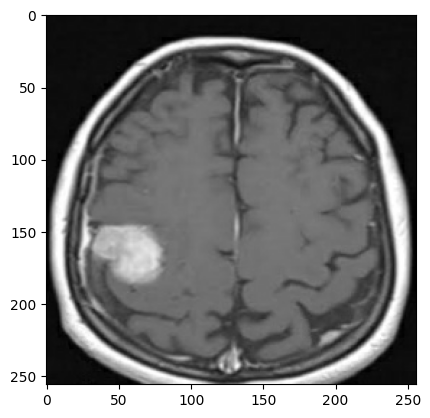

In [75]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [72]:
import numpy as np
np.argmax([0.92286426,0.06857526,0.00495577,0.00360477])
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [76]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])] #predicted label
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


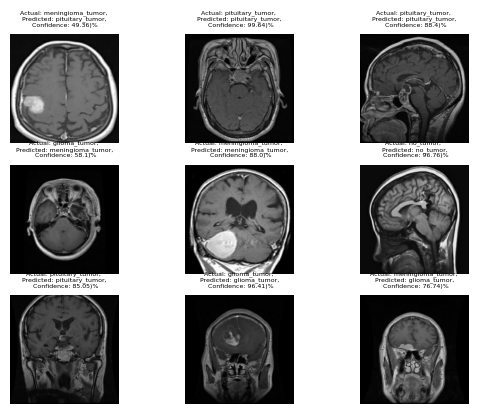

In [82]:
for image, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, image[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence})%", fontsize=6)
        plt.axis("off")


In [84]:
model_version = 1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1/assets


INFO:tensorflow:Assets written to: ../model/1/assets


In [100]:
import os

path = "/Users/juinnshengna/Desktop/mri/model"
files = [f for f in os.listdir(path) if not f.startswith('.')]
model_version = max([int(i) for i in files + [0]]) + 1
model.save(f"/Users/juinnshengna/Desktop/mri/model/{model_version}")


INFO:tensorflow:Assets written to: /Users/juinnshengna/Desktop/mri/model/2/assets


INFO:tensorflow:Assets written to: /Users/juinnshengna/Desktop/mri/model/2/assets
